2025-03-12 18:18:26.469206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 18:18:26.469630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 18:18:26.471863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 18:18:26.479299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741790906.490366   27714 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741790906.49

Epoch 1/200


W0000 00:00:1741790909.310185   27714 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3381 - val_loss: 3.1870
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5862 - val_loss: 2.3024
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7675 - val_loss: 1.6334
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2524 - val_loss: 1.1756
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1387 - val_loss: 0.9063
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8465 - val_loss: 0.7003
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7765 - val_loss: 0.5473
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7093 - val_loss: 0.4416
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6895 - val_loss: 0.3782
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6208 - val_loss: 0.3237
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5773 - val_loss: 0.3034
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5777 - val_lo

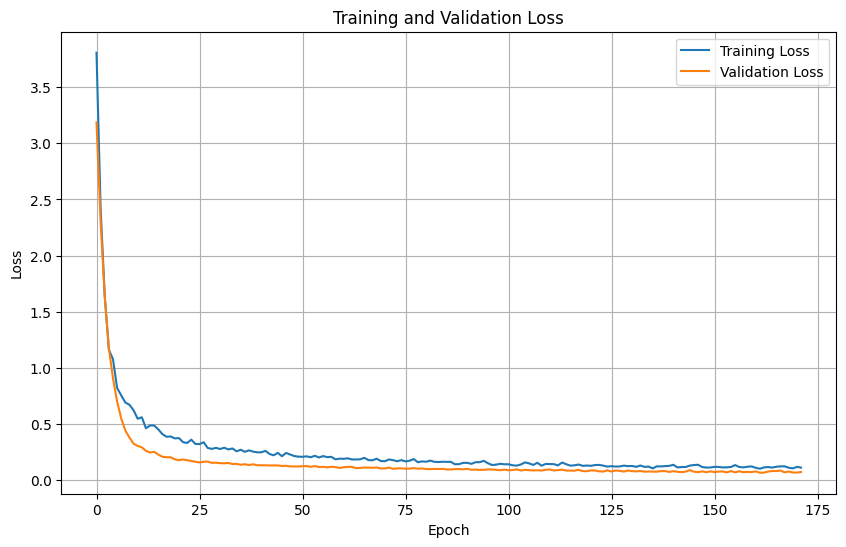

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² Score: 0.9484
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,093 (19.90 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 3,332 (13.02 KB)

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Load the CSV files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Handle missing values
numerical_features = ['Age', 'StudyTimeWeekly', 'Absences']
categorical_features = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 
                       'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

for feature in numerical_features:
    train_df[feature].fillna(train_df[feature].mean(), inplace=True)
    test_df[feature].fillna(test_df[feature].mean(), inplace=True)

train_df.dropna(subset=categorical_features, inplace=True)
test_df.dropna(subset=categorical_features, inplace=True)

# Preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])

# Split the data
X = train_df.drop('GPA', axis=1)
y = train_df['GPA']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Build a more complex model with regularization
model = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_processed, y_train,
    epochs=200,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    batch_size=32,
    verbose=1
)

# Visualize loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
if 'GPA' in test_df.columns:
    X_test = test_df.drop('GPA', axis=1)
else:
    X_test = test_df
    
X_test_processed = preprocessor.transform(X_test)
predictions = model.predict(X_test_processed)

# Save predictions
output_df = pd.DataFrame({'StudentID': test_df['StudentID'], 'PredictedGPA': predictions.flatten()})
output_df.to_csv('predictions.csv', index=False)

# Evaluate the model
val_predictions = model.predict(X_val_processed)
r2 = r2_score(y_val, val_predictions)
print(f"R² Score: {r2:.4f}")

# Feature importance analysis (for interpretation)
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # Fallback for older sklearn versions
    feature_names = []
    for name, _, _ in preprocessor.transformers:
        if name != 'remainder':
            feature_names.extend([name + '_' + str(i) for i in range(preprocessor.transform(X_train.iloc[[0]]).shape[1])])
            
print("Model Summary:")
model.summary()